In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
# Importing data
cocacola_df = pd.read_excel(r"CocaCola_Sales_Rawdata.xlsx")

In [3]:
cocacola_df.shape

(42, 2)

In [4]:
cocacola_df.head(5)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


<AxesSubplot: >

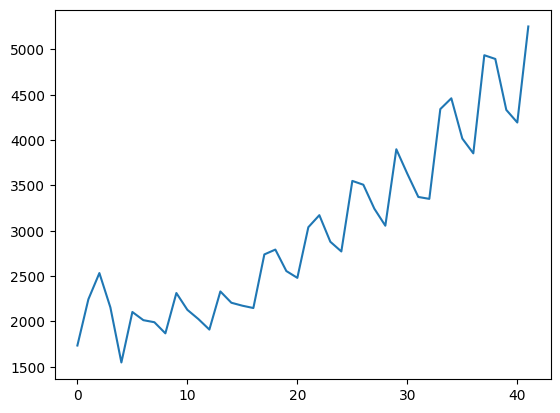

In [5]:
cocacola_df.Sales.plot()

array([[<AxesSubplot: title={'center': 'Sales'}>]], dtype=object)

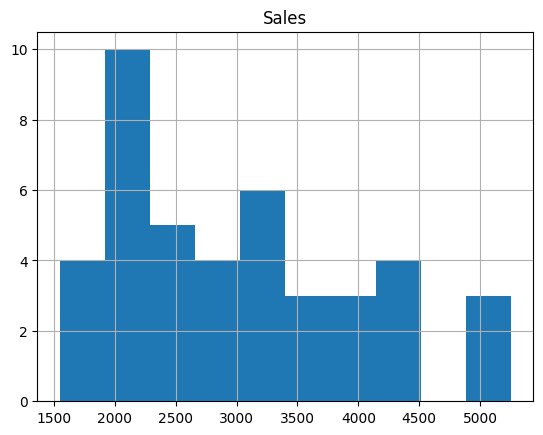

In [6]:
cocacola_df.hist()

<AxesSubplot: ylabel='Density'>

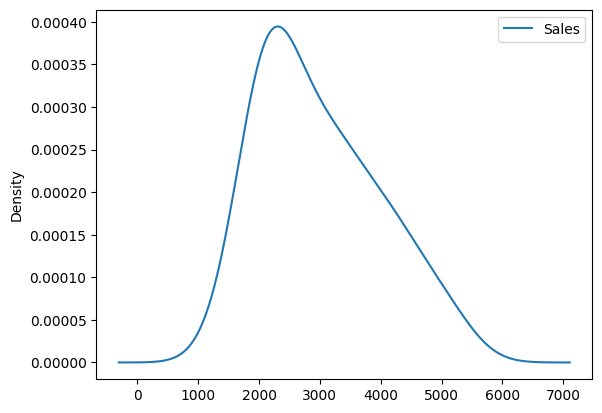

In [7]:
cocacola_df.plot(kind='kde')

### Moving Average

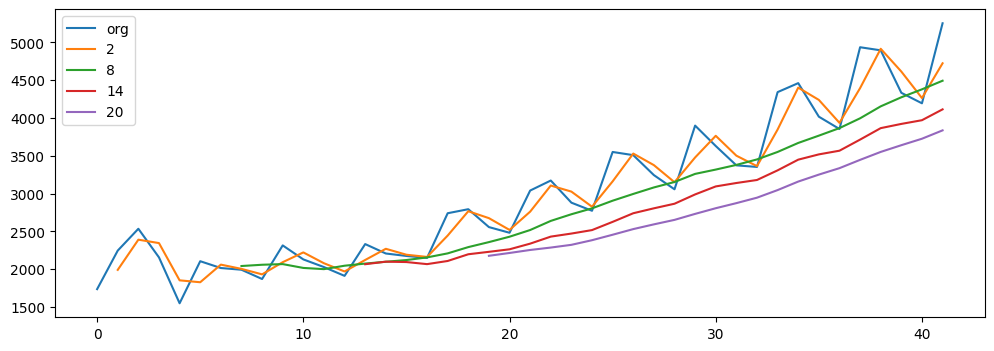

In [8]:
plt.figure(figsize=(12,4))
cocacola_df.Sales.plot(label="org")
for i in range(2,24,6):
    cocacola_df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

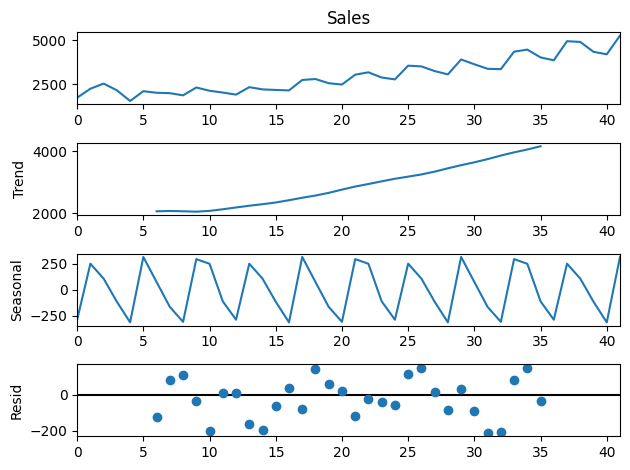

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

decompose_ts_add = seasonal_decompose(cocacola_df.Sales,period=12)
decompose_ts_add.plot()
plt.show()

## From the trend and seasonal we can see a clear trend. Hence the data is stationary. 

### ACF plots and PACF plots

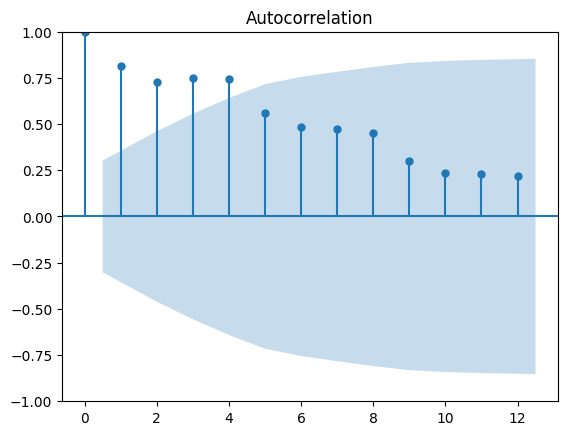

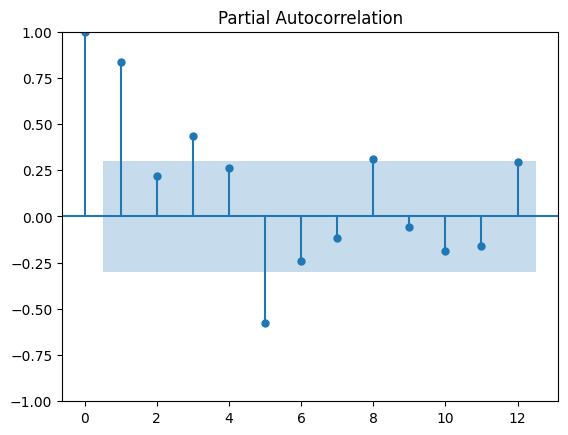

In [10]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(cocacola_df.Sales,lags=12)
tsa_plots.plot_pacf(cocacola_df.Sales,lags=12)
plt.show()

In [11]:
Train = cocacola_df.head(35)
Test = cocacola_df.tail(7)

### Evaluation Metric MAPE

In [12]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Simple Exponential Method

In [13]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

16.401825273142318

### Holt method 

In [14]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

15.891434335419715

### Holts winter exponential smoothing with additive seasonality and additive trend

In [15]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

5.241832544936149

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [16]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

4.692103335212899

In [17]:
# separate out a validation dataset
split_point = len(cocacola_df) - 10
dataset, validation = cocacola_df[0:split_point], cocacola_df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 32, Validation 10


### Persistence/ Base model

In [18]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, skiprows=1, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.iloc[:, 1]
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [19]:
# Assuming 'test' is your pandas DataFrame
test = test.reset_index(drop=True)

In [20]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
RMSE: 387.510


## ARIMA Model

In [29]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

# Load the dataset
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx', index_col='Quarter', parse_dates=True)

# Find the best ARIMA model using auto_arima
model = auto_arima(data['Sales'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stepwise=True)

# Print the summary of the best model
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -270.621
Date:                Tue, 12 Sep 2023   AIC                            557.242
Time:                        19:38:30   BIC                            570.950
Sample:                             0   HQIC                           562.234
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    281.4733     72.214      3.898      0.000     139.936     423.010
ar.L1         -1.0096      0.054    -18.741      0.000      -1.115      -0.904
ar.L2         -1.0007      0.065    -15.377      0.0

In [30]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx', index_col='Quarter', parse_dates=True)

# Create the ARIMA model
model = ARIMA(data['Sales'], order=(3, 1, 3))

# Fit the model
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   42
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -281.092
Date:                Tue, 12 Sep 2023   AIC                            576.183
Time:                        19:39:07   BIC                            588.178
Sample:                             0   HQIC                           580.551
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0111      0.179     -5.660      0.000      -1.361      -0.661
ar.L2         -0.9767      0.216     -4.518      0.000      -1.400      -0.553
ar.L3         -0.9555      0.126     -7.568      0.0

In [34]:
# Make predictions for the future
predictions = model_fit.predict(start=42, end=43)

In [35]:
predictions

42    5146.091634
43    4557.553192
Name: predicted_mean, dtype: float64

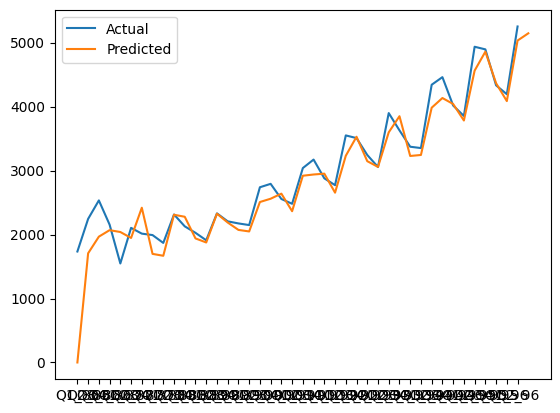

In [36]:
# Make predictions for the future
predictions = model_fit.predict(start=0, end=42)

# Plot the actual values and the predicted values
plt.plot(data['Sales'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

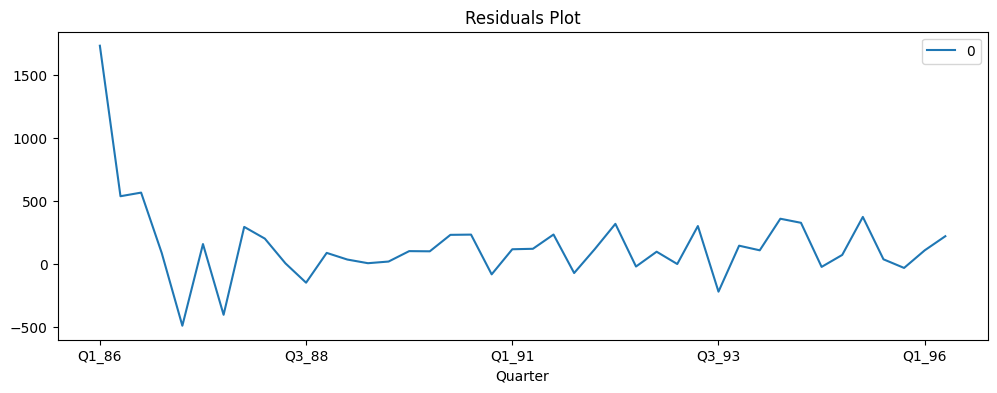

In [31]:
# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12, 4))
plt.title('Residuals Plot')
plt.show()